# Part 1: Comparing Token Usage by Language
For part one, I compared the token usage of different languages. Given that some languages (like Russian) omit articles, I assumed that Russian would use fewer tokens than English. I also tested Simplified Chinese, hoping that the symbols of Chinese would even further reduce the token usage. However, I found that this is not the case for either of these languages. In fact, I found that they consistently use **more** tokens on average. I believe this is largely based on the choice of tokenizer, as tokenizers are trained on English data and likely optimized for English. In fact, on Deepseek's own token measurement estimator, they mention that an English word is ~0.3 tokens, while a Chinese symbol is ~0.6 tokens (https://api-docs.deepseek.com/quick_start/token_usage).



The tokenizers evaluated in this project are OpenAI models found in the 'tiktoken' Python module (https://github.com/openai/tiktoken). I also then compared the information loss of queries after translation using Google's Gemma Embedding model (https://huggingface.co/google/embeddinggemma-300m) and vectorization in order to determine whether using another language was even a practical solution for reducing token usage.

In [24]:
!pip3 install google-cloud-translate
!pip3 install tiktoken
!pip3 install -U sentence-transformers
!pip3 install transformers
!pip install tqdm

In [2]:
import requests
from google.colab import userdata
api_key = userdata.get('GOOGLE_APPLICATION_CREDENTIALS')

# use the google translate API to translate from English to Russian
def translate_text(text, source, target):
    url = "https://translation.googleapis.com/language/translate/v2"
    params = {
        "q": text,
        "target": target,
        "source": source,
        "key": api_key,
    }

    response = requests.post(url, data=params)
    return response.json()

In [3]:
def get_translated_sentences(src_language, target_language, sentences):
  # translate each sentence into russian using google translate
  translation_responses = [translate_text(t, src_language, target_language) for t in sentences]
  # get the translated sentences
  return [r['data']['translations'][0]['translatedText'] for r in translation_responses]

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import tiktoken

# get tokenizer
def get_tokenizer(model_type):
  # get the deepseek tokenizer
  if model_type == 'deepseek':
    ds_model_name = "deepseek-ai/deepseek-llm-7b-base"
    ds_tokenizer = AutoTokenizer.from_pretrained(ds_model_name)
    return ds_tokenizer
  else:
    # use tiktoken to count tokens, code copied from OpenAI's github: https://github.com/openai/tiktoken
    enc = tiktoken.get_encoding(model_type)

    # To get the tokeniser corresponding to a specific model in the OpenAI API:
    tiktoken_tokenizer = tiktoken.encoding_for_model("gpt-4o")
    return tiktoken_tokenizer

In [5]:
def get_tokenized_sentences(src_sentences, translated_sentences, tokenizer_model):
  # tokenize both the original sentences and the translated sentences
  tokenized_src_sentences = []
  tokenized_target_sentences = []

  # get the tokenizer to test with
  tokenizer = get_tokenizer(tokenizer_model)

  for i in range(len(src_sentences)):
    tokenized_src_sentences.append(tokenizer.encode(src_sentences[i]))
    tokenized_target_sentences.append(tokenizer.encode(translated_sentences[i]))

  return tokenized_src_sentences, tokenized_target_sentences

In [21]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_token_usages(tokenized_src_sentences, tokenized_target_sentences, src_language="Source", target_language="Target", show=True):
  # get token counts for english and russian sentences
  src_token_counts = [len(tokens) for tokens in tokenized_src_sentences]
  target_token_counts = [len(tokens) for tokens in tokenized_target_sentences]

  sentence_indices = range(len(tokenized_src_sentences))

  token_ratio = np.sum(src_token_counts) / np.sum(target_token_counts)

  if not show: return token_ratio

  # we will use a bar chart to compare token usages
  plt.figure(figsize=(14, 7))
  bar_width = 0.35

  plt.bar([i - bar_width/2 for i in sentence_indices], src_token_counts, bar_width, label=f'{src_language} Tokens', color='skyblue')
  plt.bar([i + bar_width/2 for i in sentence_indices], target_token_counts, bar_width, label=f'{target_language} Tokens', color='lightcoral')

  plt.xlabel('Sentence Index')
  plt.ylabel('Number of Tokens')
  plt.title(f'Token Usage Comparison: {src_language} vs. {target_language} Sentences (Totals: {src_language}={np.sum(src_token_counts)}, {target_language}={np.sum(target_token_counts)})')
  plt.xticks(sentence_indices)
  plt.legend()
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

  return token_ratio

In [7]:
# use embedding model vectorization to analyze the information loss between translations
''' Google Gemma Citation
@article{embedding_gemma_2025,
    title={EmbeddingGemma: Powerful and Lightweight Text Representations},
    author={Schechter Vera, Henrique* and Dua, Sahil* and Zhang, Biao and Salz, Daniel and Mullins, Ryan and Raghuram Panyam, Sindhu and Smoot, Sara and Naim, Iftekhar and Zou, Joe and Chen, Feiyang and Cer, Daniel and Lisak, Alice and Choi, Min and Gonzalez, Lucas and Sanseviero, Omar and Cameron, Glenn and Ballantyne, Ian and Black, Kat and Chen, Kaifeng and Wang, Weiyi and Li, Zhe and Martins, Gus and Lee, Jinhyuk and Sherwood, Mark and Ji, Juyeong and Wu, Renjie and Zheng, Jingxiao and Singh, Jyotinder and Sharma, Abheesht and Sreepat, Divya and Jain, Aashi and Elarabawy, Adham and Co, AJ and Doumanoglou, Andreas and Samari, Babak and Hora, Ben and Potetz, Brian and Kim, Dahun and Alfonseca, Enrique and Moiseev, Fedor and Han, Feng and Palma Gomez, Frank and Hernández Ábrego, Gustavo and Zhang, Hesen and Hui, Hui and Han, Jay and Gill, Karan and Chen, Ke and Chen, Koert and Shanbhogue, Madhuri and Boratko, Michael and Suganthan, Paul and Duddu, Sai Meher Karthik and Mariserla, Sandeep and Ariafar, Setareh and Zhang, Shanfeng and Zhang, Shijie and Baumgartner, Simon and Goenka, Sonam and Qiu, Steve and Dabral, Tanmaya and Walker, Trevor and Rao, Vikram and Khawaja, Waleed and Zhou, Wenlei and Ren, Xiaoqi and Xia, Ye and Chen, Yichang and Chen, Yi-Ting and Dong, Zhe and Ding, Zhongli and Visin, Francesco and Liu, Gaël and Zhang, Jiageng and Kenealy, Kathleen and Casbon, Michelle and Kumar, Ravin and Mesnard, Thomas and Gleicher, Zach and Brick, Cormac and Lacombe, Olivier and Roberts, Adam and Sung, Yunhsuan and Hoffmann, Raphael and Warkentin, Tris and Joulin, Armand and Duerig, Tom and Seyedhosseini, Mojtaba},
    publisher={Google DeepMind},
    year={2025},
    url={https://arxiv.org/abs/2509.20354}
}
'''

# code copied and modified from https://huggingface.co/google/embeddinggemma-300m
from sentence_transformers import SentenceTransformer

# Download from the 🤗 Hub
model = SentenceTransformer("google/embeddinggemma-300m")


def get_similiarity_scores(original_sentences, backtranslated_sentences):
  original_documents = original_sentences
  backtranslated_documents = backtranslated_sentences

  original_document_embeddings = model.encode_document(original_documents)
  backtranslated_document_embeddings = model.encode_document(backtranslated_documents)

  # Compute similarities to determine a ranking
  similarities = model.similarity(original_document_embeddings, backtranslated_document_embeddings)

  return similarities

In [22]:
def visualize_losses(similarity_scores, show):
  # get similarity scores (note that they are output as a tensor
  # where similarities[i][i] is the similarity score between the original document
  # and the corresponding backtranslated document
  losses = [1 - similarity_scores[i][i] for i in range(len(similarity_scores))]
  avg_loss = np.mean(losses)

  if not show: return avg_loss

  plt.figure(figsize=(12, 6))
  sentence_indices = range(len(losses))
  plt.bar(sentence_indices, losses)
  plt.ylim(0,1)
  plt.xlabel('Sentence Index')
  plt.ylabel('Information Loss (1 - Similarity Score)')
  plt.title(f'Information Loss per Sentence After Back-Translation (Avg: {avg_loss * 100: .4f}%)')
  plt.xticks(sentence_indices)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()
  return avg_loss

In [9]:
# more supported languages by the google translate api can be found at https://docs.cloud.google.com/translate/docs/languages
lang = {
    'english': 'en',
    'russian': 'ru',
    'chinese': 'zh'
}

In [10]:
# models 1-4 are OpenAI models, and the last model is a deepseek model
tokenizer_models = ['o200k_base', 'cl100k_base', 'p50k_base', 'r50k_base', 'deepseek']

In [11]:
# list of 30 random sentences to test, generated by ChatGPT
original_sentences = [
    "Even though he had planned everything weeks in advance, the unexpected storm forced him to change his travel schedule at the very last minute.",
    "The new software update, which was supposed to make things easier, actually caused more confusion among the employees than anyone anticipated.",
    "After spending the entire afternoon looking for her missing phone, she realized it had been in her backpack the whole time, buried under a stack of notebooks.",
    "When we finally reached the top of the mountain, exhausted and covered in dust, the breathtaking view made all the effort feel completely worthwhile.",
    "She tried to explain that the mistake wasn’t her fault, but nobody seemed interested in listening until the director reviewed the documents himself.",
    "Although the horses had been fed earlier that morning, they were still restless because of the loud construction happening near the stables.",
    "By the time I understood what he was trying to say, he had already left the room and I had no opportunity to ask any clarifying questions.",
    "They promised they would finish the financial report by Friday, but several unexpected issues pushed the deadline into the middle of next week.",
    "I was surprised to learn that the quiet neighbor who rarely speaks to anyone has actually traveled to more than forty countries.",
    "During the interview, she gave such thoughtful and sincere answers that everyone in the room immediately felt connected to her story.",
    "Once the meeting started, it became clear that half the team hadn’t read any of the preparation materials, which slowed everything down significantly.",
    "Every time I think I’ve solved the bug in the code, a new error appears somewhere else and makes me question my entire approach.",
    "He bought the old farmhouse with the intention of renovating it, but the deeper he looked, the more problems he discovered hidden behind the walls.",
    "While we were driving through the mountains, the sun suddenly broke through the clouds, lighting up the entire valley in a way that felt almost magical.",
    "She kept all the letters he ever wrote to her in a small wooden box because they reminded her of a time when life felt simpler and more hopeful.",
    "Even after double-checking the instructions several times, he still couldn’t figure out why the machine refused to start properly.",
    "The committee spent nearly four hours debating a single paragraph of the proposal, which delayed the entire project timeline.",
    "She didn’t expect the conversation to become emotional, but the moment she mentioned her childhood, everything suddenly shifted.",
    "As we walked through the crowded marketplace, the mixture of unfamiliar smells, bright colors, and loud voices felt overwhelming at first.",
    "After months of planning, the event finally took place, but almost nothing went according to schedule.",
    "He wanted to decline the offer politely, yet something about the man’s tone made him feel obligated to agree.",
    "The dog barked nonstop throughout the night because a raccoon kept trying to climb onto the back porch.",
    "Although she knew the presentation wasn’t perfect, she delivered it with enough confidence that the audience barely noticed the flaws.",
    "By the time the documents arrived, the deadline had already passed, leaving everyone scrambling to find a solution.",
    "When I asked her why she kept postponing the decision, she said she was afraid of choosing the wrong path.",
    "The old library smelled like dust and parchment, but it had a quiet charm that made it feel almost sacred.",
    "He tried to repair the fence himself, but the tools he borrowed were too old and kept breaking in his hands.",
    "The moment we stepped off the plane, we were greeted by a wave of humid air that made it hard to breathe.",
    "She looked through the photos from last year’s trip and realized how much she had changed since then.",
    "Despite all the challenges they faced, they never gave up on the idea that things could still turn out better than expected."
]

In [12]:
def compare_languages(src, target, tokenizer_model):
  # translate original sentences to a target language
  translated_sentences = get_translated_sentences(src, target, original_sentences)

  ## evaluate information loss - aka answer the following question: if we could really reduce token usage by changing the language in which we query,
  # would we lose information?

  # get the back-translated sentences from the responses
  backtranslated_sentences = get_translated_sentences(target, src, translated_sentences)
  similarity_scores = get_similiarity_scores(original_sentences, backtranslated_sentences)
  visualize_losses(similarity_scores)

  ## perform the token usage analysis between a source and a target language

  # get the tokenized versions of each
  tokenized_src, tokenized_target = get_tokenized_sentences(original_sentences, translated_sentences, tokenizer_model)
  # visualize token usage
  visualize_token_usages(tokenized_src, tokenized_target)

In [13]:
tokenizer_model = tokenizer_models[0]
compare_languages(lang['english'], lang['russian'], tokenizer_model)

In [14]:
compare_languages(lang['english'], lang['chinese'], tokenizer_model)

# Part 2: Prompt "Compression"

I also wanted to test the effects of removing articles and punctuation from prompts to see if I can reduce the number of tokens simply by picking out the less important pieces. The way I will evaluate this is again by vectorizing the augmented sentence and comparing similarity scores using Google's embedding model.

In [15]:
import re

def remove_punctuation_and_articles(sentence):
  sentence_no_punct = re.sub(r'[.,!?;:"\\]', '', sentence)
  words = sentence_no_punct.lower().split()
  articles = {'a', 'an', 'the'}
  filtered_words = [word for word in words if word not in articles]

  return ' '.join(filtered_words)

In [16]:
def evaluate_original_vs_compression(original_sentences, tokenizer_model, show):
  compressed_sentences = [remove_punctuation_and_articles(s) for s in original_sentences]
  similarity_scores_comp = get_similiarity_scores(original_sentences, compressed_sentences)
  avg_loss = visualize_losses(similarity_scores_comp, show)
  tokenized_orig, tokenized_comp = get_tokenized_sentences(original_sentences, compressed_sentences, tokenizer_model)
  token_ratio = visualize_token_usages(tokenized_orig, tokenized_comp, 'Original', 'Compressed', show)
  return avg_loss, token_ratio


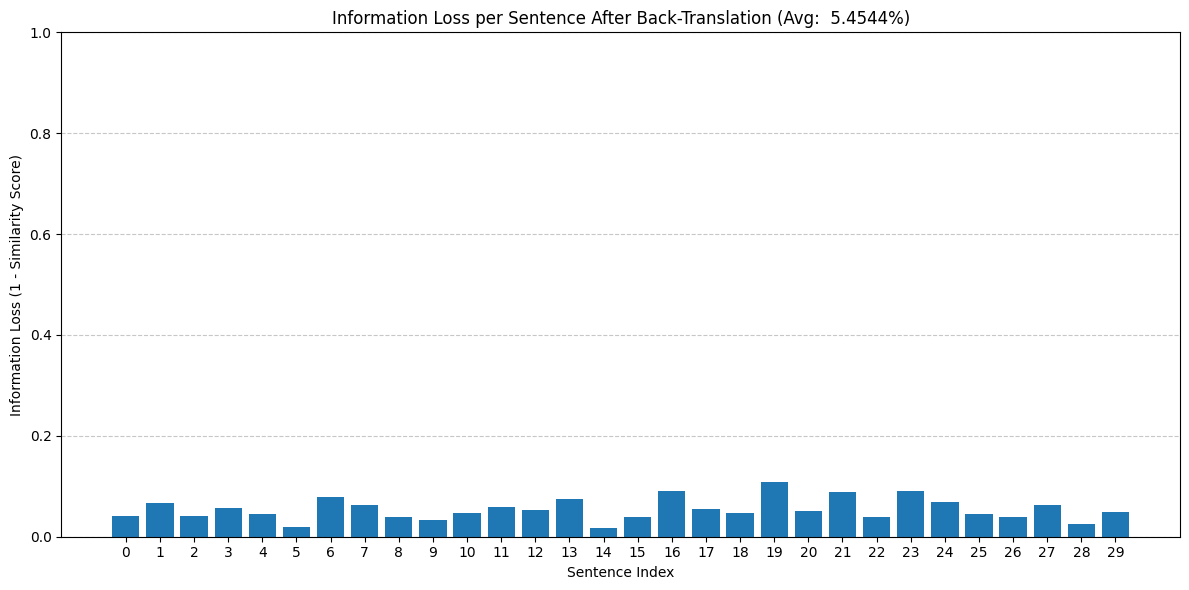

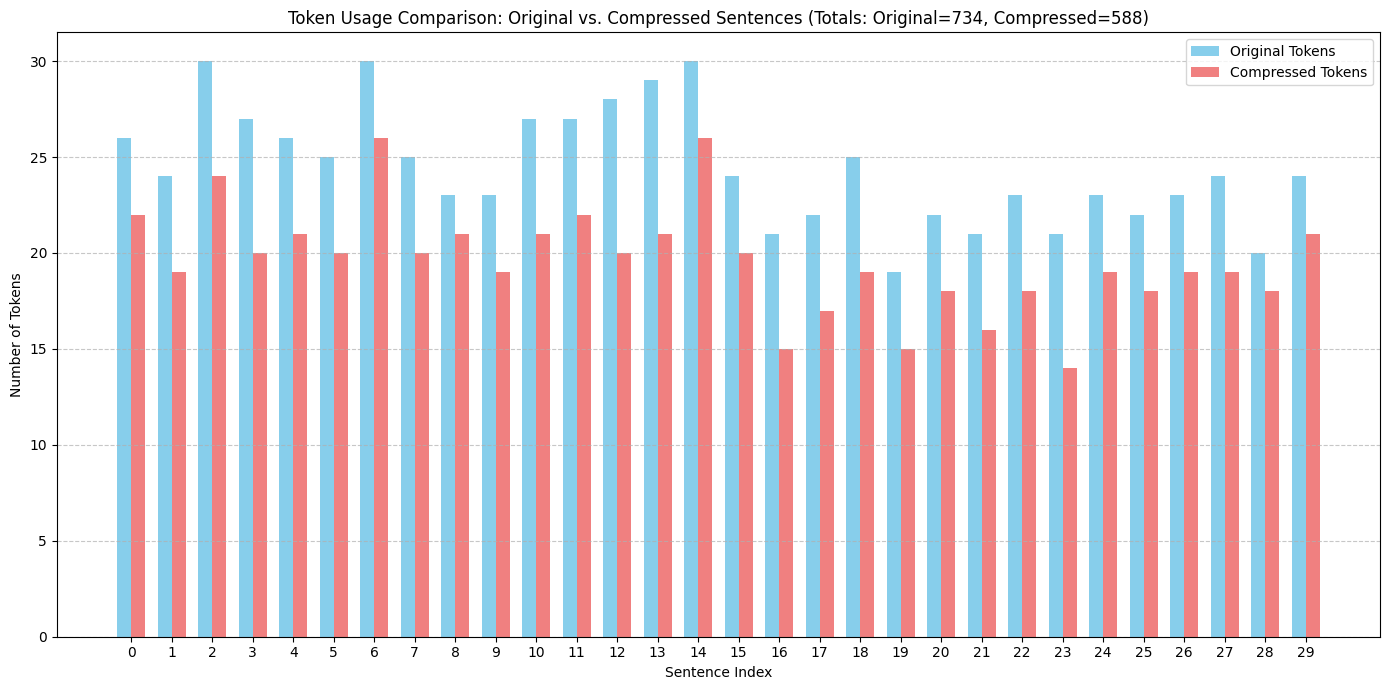

AVERAGE LOSS: 0.05454361066222191
AVERAGE TOKEN RATIO (ORIGINAL / COMPRESSED): 1.248299319727891


In [27]:
avg_loss, avg_token_ratio = evaluate_original_vs_compression(original_sentences, tokenizer_model)
print(f"AVERAGE LOSS: {avg_loss}")
print(f"AVERAGE TOKEN RATIO (ORIGINAL / COMPRESSED): {avg_token_ratio}")

As shown above, compressed sentences remain semantically similar (~5% information loss), but they use fewer tokens. At scale, this could potentially be very effective if the loss stays the same.

In [18]:
additional_paragraphs = [
    "When the train suddenly stopped in the middle of the countryside, everyone in the carriage looked around in confusion, unsure of what had just happened. The conductor announced that a herd of sheep had wandered onto the tracks, which caused an immediate and unexpected delay. At first, people were irritated, checking their watches and complaining quietly, but as time passed, the mood softened. A group of travelers gathered by the windows, watching the shepherd and his dog try to coax the animals away from the rails. It wasn’t long before the frustration turned into amusement, and several passengers even began taking photos, laughing at the absurdity of the situation.",
    "The old library had a smell that lingered in your memory long after you left—a mixture of dust, aged paper, and something faintly sweet that no one could ever quite identify. Rows of tall wooden shelves stretched toward the high ceiling, their arrangement forming narrow corridors where the sound of footsteps echoed like whispers. Students and researchers came seeking quiet, but what they found was something more: a sense of timelessness that made the outside world feel irrelevant. The librarians, who seemed to know the history of every book, walked with deliberate calm, offering guidance only when necessary. It was the kind of place that encouraged curiosity simply by existing.",
    "Driving up the narrow mountain road at sunset always made him nervous, not because of the height but because of the way the light changed so quickly. One moment the entire valley was flooded with golden brightness, and the next, the shadows grew long and uncertain, hiding dips and bends in the road. He kept both hands on the steering wheel, gripping just a little too tightly, while the wind pressed against the car like an invisible force. Yet despite his anxiety, he loved the view: endless pine forests, distant peaks dusted with snow, and the faint outline of a river carving its way through the canyon far below. It was a reminder of how small he really was, in the best possible way.",
    "By the time the meeting reached its third hour, half the team had already lost track of the agenda, and the other half was pretending to take notes while scrolling through unrelated emails. The project manager insisted on reviewing every detail—even the ones everyone had agreed on weeks earlier—which slowed the discussion to an agonizing crawl. At one point, someone suggested taking a short break, but this idea was quickly dismissed because “we’re almost done,” a phrase that turned out to be wildly inaccurate. When they finally wrapped up, people stumbled out of the conference room as if they had been trapped underground, grateful just to breathe fresh air again.",
    "He liked walking through the city late at night, when the crowds had thinned and the neon signs cast long reflections across the wet pavement. It was the only time he felt the noise of the world quiet down enough for his thoughts to untangle. As he passed the closed shops and empty bus stops, he found himself imagining the stories of the people who had stood there earlier: the hurried worker catching a ride home, the lonely traveler with a heavy suitcase, the group of teenagers laughing too loudly. The city held a thousand lives within its streets, all of them overlapping and intersecting in ways no one would ever fully understand. Somehow, that mystery comforted him.",
    "The garden behind the old house had fallen into a kind of gentle chaos, with vines stretching across broken stone paths and wildflowers growing wherever they pleased. Birds nested in the tangled branches of an untrimmed apple tree, and bees hummed lazily around clusters of lavender. She often came here in the evenings, simply to breathe in the warm air and let her mind wander. Despite its disordered appearance, the place had a strange peace to it, as though time moved differently within its borders. Even on days when everything else felt overwhelming, the overgrown garden offered a moment of stillness she could rely on.",
    "The small coastal town woke slowly each morning, as if reluctant to leave behind its dreams of wind and waves. Fishermen gathered at the docks before sunrise, their quiet conversations blending with the rhythmic clatter of equipment being prepared for the day. The salty air carried the faint scent of seaweed and diesel fuel, familiar and oddly comforting. Shops along the waterfront opened one by one, their doors creaking softly as shopkeepers swept sand from their thresholds. By mid-morning, the streets filled with tourists and locals alike, all moving at the same unhurried pace that defined life by the ocean.",
    "He always found coffee shops fascinating, not because of the drinks but because of the strange blend of lives happening in the same space. At one table, a student typed furiously, trying to finish an overdue assignment, while at another, two friends laughed so loudly that even the barista couldn’t help but smile. A couple sat by the window in total silence, communicating through brief looks rather than words. The espresso machine hissed and sputtered like a living creature, punctuating the mix of conversations and music. It was a place where strangers shared a moment without ever acknowledging each other.",
    "The museum’s new exhibit featured artifacts so old that it was difficult to imagine the people who once used them. Pottery painted with fading motifs, tools carved from stone, and fragments of woven cloth were displayed behind glass, illuminated by carefully angled lights. Visitors moved slowly through the rooms, whispering as though afraid to disturb the ghosts of ancient civilizations. Some pieces were remarkably well preserved, hinting at lives full of rituals, conflicts, and quiet routines. Standing among them, she felt both connected to the distant past and humbled by how much of it remained mysterious.",
    "Rain hammered against the windows of the cabin, drowning out every other sound. Inside, the fire crackled steadily, casting warm light across the wooden floor and softening the edges of the room. He sat in a worn armchair with a blanket wrapped around his shoulders, listening to the storm rage outside. It had been a long week, and the isolation of the cabin felt like a blessing rather than a burden. With no cell service and no obligations pressing in on him, the world seemed to shrink to the comforting glow of the fireplace. For the first time in months, he felt fully at ease.",
    "Her grandmother’s attic was a treasure chest of forgotten memories, filled with dusty trunks, faded photographs, and stacks of brittle letters tied with fraying ribbon. Each object hinted at a story she had never heard, inviting her to imagine lives lived long before she was born. Sunlight filtered through a small circular window, illuminating particles of dust that floated like tiny stars in the air. As she sorted through the boxes, she discovered unexpected pieces of her family’s history tucked between old clothing and keepsakes. The attic felt alive with echoes of the past, whispering secrets too faint to fully understand.",
    "The forest trail twisted through dense stands of trees, their branches forming a canopy so thick that only narrow beams of sunlight reached the forest floor. Birds called to each other from hidden perches, their songs mingling with the rustle of leaves stirred by the breeze. Every now and then, he paused to admire the moss-covered logs and small wildflowers peeking out from the underbrush. Hiking here always cleared his mind, replacing stress with a sense of quiet purpose. Though the trail was familiar, each walk revealed something new—a different scent, a unique shadow, or a creature darting across the path.",
    "As the festival lights flickered on, the town square began to fill with people drawn by music and the smell of fresh food. Stalls lined the streets, offering handmade crafts, warm pastries, and brightly colored decorations. Children darted between the crowds, chasing each other with unrestrained joy, while adults gathered in small groups to chat and laugh. Musicians played lively tunes from a small stage, their energy spreading through the air like sunlight. For one night each year, the town felt transformed—a place where worries softened and everything seemed touched by celebration.",
    "The long-distance train ride stretched through endless fields and rolling hills, offering views that felt oddly nostalgic even to those who had never been there before. The rhythmic clacking of the wheels on the tracks created a steady soundtrack that encouraged reflection. Some passengers slept with their heads against the window, while others read quietly or stared at the changing landscape. The conductor walked through the aisles periodically, checking tickets with a gentle nod. As hours passed, the world outside shifted from farmland to forest to distant mountains, each scene passing like a memory just out of reach.",
    "Working at the small-town bakery was not the career she had imagined for herself, yet she found unexpected comfort in its daily routines. Each morning began before dawn, with the warm scent of rising dough filling the kitchen. She shaped loaves, pastries, and rolls with practiced movements, enjoying the rhythm of the work. Customers arrived soon after sunrise, greeting her with familiar smiles and small bits of conversation. Though the job was simple, it grounded her in a way she hadn’t felt before—offering a sense of belonging she hadn’t known she needed.",
    "The river wound through the valley like a silver ribbon, reflecting the colors of the sky as the sun dipped behind the mountains. On warm evenings, families gathered along the riverbank to fish, picnic, or simply enjoy the fading light. Children skipped stones across the surface, cheering when one bounced more than expected. The gentle murmur of flowing water dulled the sounds of the nearby town, creating an atmosphere of calm that settled over everyone present. Even those who came alone felt accompanied by the natural beauty surrounding them.",
    "She enjoyed taking long bus rides through the city, not because of the destination but because of the opportunity to observe the quiet dramas unfolding around her. Elderly passengers climbed aboard with careful steps, clutching their bags as though they contained precious secrets. Teenagers whispered excitedly about weekend plans. A tired worker stared out the window, lost in thought as buildings and advertisements passed in a blur. Each person seemed to inhabit their own world, yet they all shared the same cramped space for a brief moment in time.",
    "The hotel lobby was a study in controlled elegance, with marble floors, towering indoor plants, and a chandelier that sparkled like a cluster of distant stars. Guests moved through the space with varying degrees of exhaustion, dragging suitcases or clinging to cups of coffee. Behind the front desk, employees maintained a calm professionalism that bordered on superhuman. Watching them work, he wondered how many stories passed through the lobby each day—honeymoons, business trips, reunions, and quiet escapes—all overlapping without ever truly touching.",
    "Late in the afternoon, the marketplace grew lively as merchants called out prices and customers navigated through narrow aisles packed with color and noise. Spices filled the air with intoxicating aromas, while vibrant fabrics fluttered from wooden stalls. Street performers played music that blended seamlessly with the hum of bargaining voices. She found the energy overwhelming at times, but there was something thrilling about the chaos, as though the entire marketplace pulsed with life. Even if she bought nothing, she always left feeling renewed.",
    "The classroom felt strangely empty after the bell rang, leaving behind only scattered papers and the faint scent of dry-erase markers. The teacher sat quietly at her desk, reflecting on the day’s lessons and the small victories that often went unnoticed. Sometimes she wondered if her students realized how much she cared about their progress, or whether they saw her simply as another adult telling them what to do. But when she recalled the moments when a concept finally clicked for someone, she felt reassured that her efforts mattered.",
    "The old cinema had become a relic of a bygone era, with velvet seats that squeaked when you sat down and a projector that hummed like a tired machine. Despite its age, people still flocked there on weekends, drawn by the charm of watching films in a place that felt untouched by modern trends. The smell of buttery popcorn filled the air, and the dim lights created an atmosphere of anticipation. When the movie finally began, the imperfections in the projection only added to its magic, reminding everyone that some experiences were valuable precisely because they weren’t perfect.",
    "Walking through the art studio, she felt surrounded by half-finished ideas waiting to be shaped into something meaningful. Canvases leaned against the walls, each covered in bold strokes of color that hinted at landscapes, portraits, or abstract dreams. Jars of brushes filled the tables, some stained with paint that had dried weeks ago. The space smelled faintly of turpentine and creativity. She loved the sense of possibility it offered—a place where mistakes were part of the process and inspiration could strike at any moment.",
    "The hiking lodge buzzed with conversation as travelers from all over the world gathered to warm themselves by the large stone fireplace. Maps were spread out on wooden tables, with groups discussing trails they had conquered and ones they hoped to attempt the next day. The lodge’s staff served steaming bowls of soup that filled the room with comforting aromas. Even strangers felt like companions here, united by shared exhaustion and a love for the mountains. It was the kind of place where friendships formed effortlessly.",
    "As she cycled along the quiet country road, the sound of her tires on the pavement blended with the chirping of crickets hidden in the tall grass. Farmhouses dotted the landscape, each one surrounded by fields that glowed golden in the late afternoon sun. Occasionally, a car passed slowly, the driver offering a friendly wave. The ride had no particular purpose beyond clearing her mind and enjoying the scenery. With each mile, she felt her worries loosen their grip, replaced by a sense of freedom she rarely experienced elsewhere.",
    "The harbor bustled with activity as workers loaded crates onto ships bound for far-off destinations. The air smelled of salt, metal, and freshly cut rope, mingling into a scent that spoke of long journeys and unpredictable weather. Seagulls circled overhead, squawking loudly in hopes of snatching an easy meal. Tourists gathered at the edge of the docks, captivated by the organized chaos. Watching the ships depart, he wondered what new adventures awaited the crews beyond the horizon.",
    "The tiny neighborhood café had an atmosphere that made people want to linger. Soft music drifted from hidden speakers, and the warm lighting created pockets of coziness in every corner. Regular customers greeted each other with familiarity, while newcomers quickly found themselves drawn into easy conversation. The barista had an uncanny ability to remember everyone’s favorite drink, and the pastries were always impossibly fresh. It was the kind of place that felt like home even on your first visit.",
    "The rooftop garden offered a rare refuge from the noise of the city below. Planters overflowing with herbs and flowers lined the edges, their scents carried by the gentle breeze. People came to read, relax, or simply enjoy the view of skyscrapers rising like giants around them. In the evenings, the lights of the city flickered to life, turning the rooftop into a quiet island floating above a sea of activity. It was a reminder that calm could be found even in the most crowded places.",
    "The old clock tower chimed every hour, its deep, resonant bells echoing through the narrow streets of the town. Children often stopped what they were doing just to count the strikes, while adults used the sound as a natural reminder of the passing day. Inside the tower, gears and pulleys worked with slow precision, maintaining a rhythm that had endured for generations. Though many modern devices had made it unnecessary, the town kept the clock running as a tribute to tradition. Its steady presence brought a sense of continuity that everyone appreciated.",
    "On the outskirts of the city, an abandoned factory stood as a monument to a time when the region had thrived on manufacturing. Rusted beams jutted from the crumbling walls, and broken windows allowed wind to whistle through the empty halls. Graffiti covered the remaining surfaces, turning the ruins into an accidental art gallery. While most people avoided the area, a few curious visitors came to explore its decaying beauty, imagining the noise and activity that once filled the space. Despite its desolation, the factory possessed a strange and haunting charm.",
    "The marketplace was already bustling by the time she arrived, its narrow pathways crowded with vendors calling out prices and customers bargaining with playful determination. Brightly colored fabrics fluttered in the morning breeze, mixing with the scent of roasted nuts and fresh bread that drifted from nearby stalls. As she wandered through the maze of tables, she paused to examine handmade pottery, intricate jewelry, and baskets woven with astonishing precision. The noise was constant—laughter, chatter, the clatter of crates being moved—but it all blended into a kind of energetic harmony. Even though she didn’t need to buy anything, she found herself lingering, drawn in by the vibrant chaos.",
]

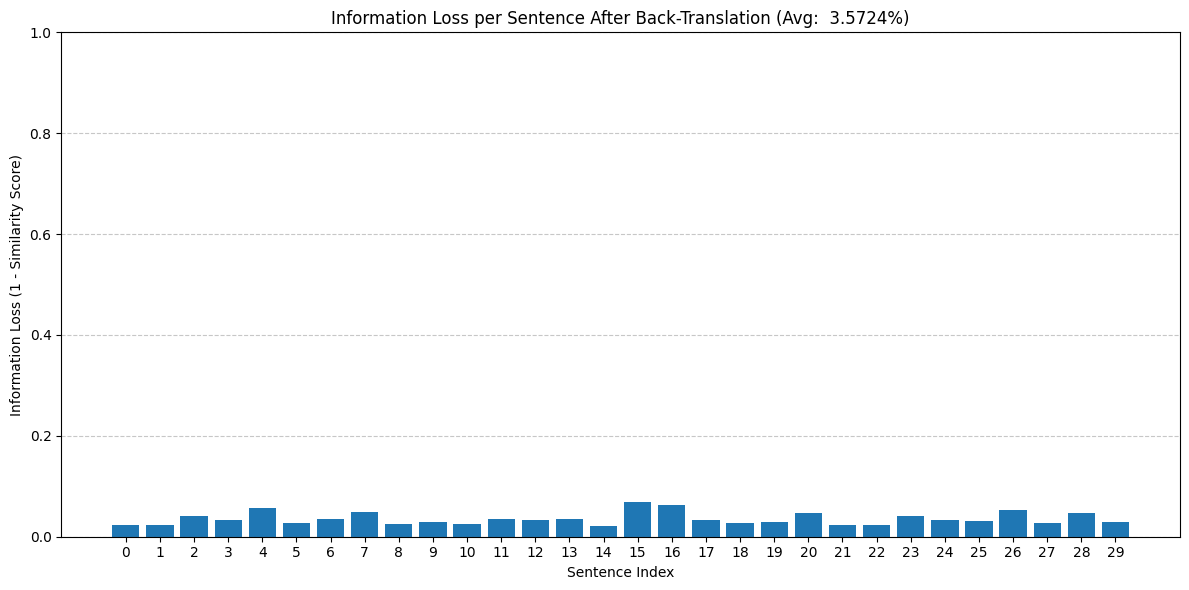

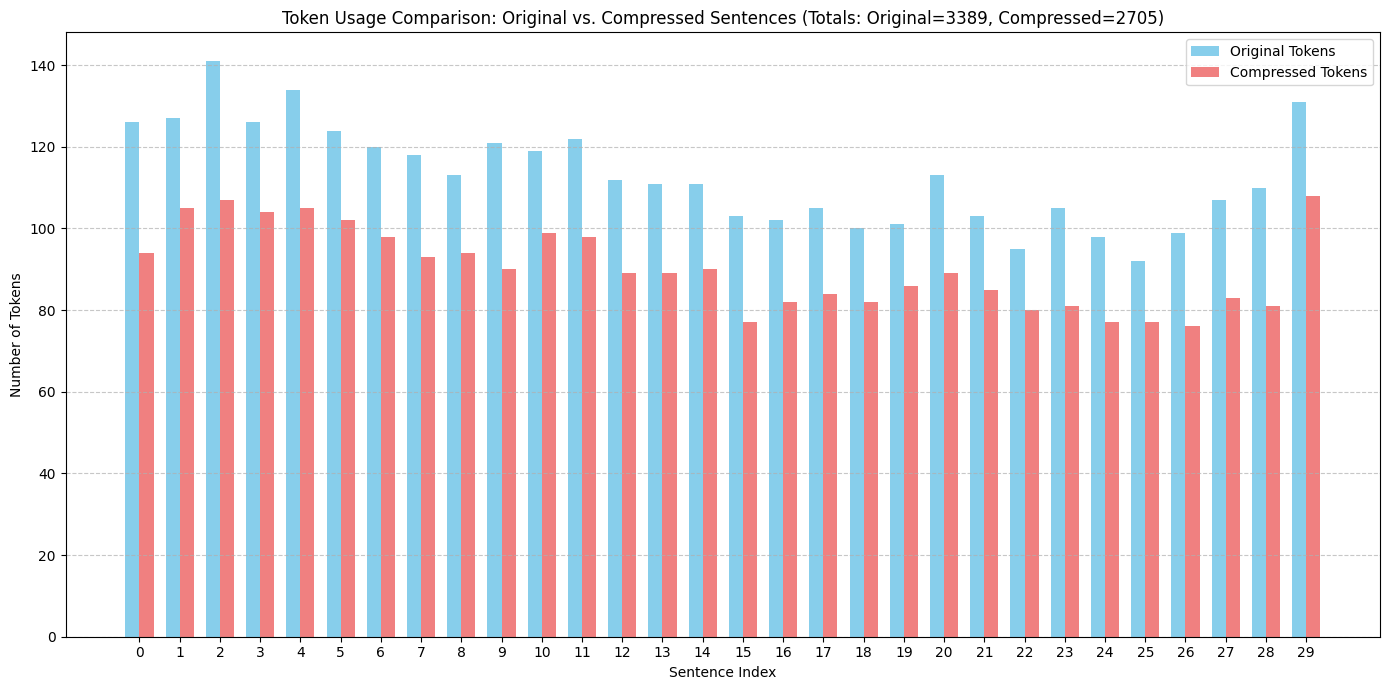

AVERAGE LOSS: 0.03572447970509529
AVERAGE TOKEN RATIO (ORIGINAL / COMPRESSED): 1.2528650646950092


In [28]:
# another test with a little more text
avg_loss, avg_token_ratio = evaluate_original_vs_compression(additional_paragraphs, tokenizer_model)
print(f"AVERAGE LOSS: {avg_loss}")
print(f"AVERAGE TOKEN RATIO (ORIGINAL / COMPRESSED): {avg_token_ratio}")

When scaled up (albeit not very much), the semantic meaning remains similar and the token usage still remains less.

In [26]:
# do n iterations on the same dataset, getting the overall average loss, this works because the tokenizer is stateless
from tqdm import trange

n = 30
losses = []
token_ratios = []

for i in trange(n):
  avg_loss, token_ratio = evaluate_original_vs_compression(additional_paragraphs, tokenizer_model, show=False)
  losses.append(avg_loss)
  token_ratios.append(token_ratio)

print(f"AVERAGE LOSS: {np.mean(losses)}")
print(f"AVERAGE TOKEN RATIO (ORIGINAL / COMPRESSED): {np.mean(token_ratios)}")

100%|██████████| 30/30 [16:57<00:00, 33.90s/it]

AVERAGE LOSS: 0.03572447970509529
AVERAGE TOKEN RATIO (ORIGINAL / COMPRESSED): 1.252865064695009


In [30]:
# an excerpt from An Introduction to Statistical Learning with Applications in Python
one_large_text = [
    """
    As discussed in Chapter 2, linear regression is an example of a parametric approach because it assumes a linear functional form for f(X). Parametric methods have several advantages. They are often easy to fit, because one need estimate only a small number of coefficients. In the case of linear re- gression, the coefficients have simple interpretations, and tests of statistical significance can be easily performed. But parametric methods do have a disadvantage: by construction, they make strong assumptions about the form of f(X). If the specified functional form is far from the truth, and prediction accuracy is our goal, then the parametric method will perform poorly. For instance, if we assume a linear relationship between X and Y but the true relationship is far from linear, then the resulting model will provide a poor fit to the data, and any conclusions drawn from it will be suspect.
In contrast, non-parametric methods do not explicitly assume a para- metric form for f(X), and thereby provide an alternative and more flexi- ble approach for performing regression. We discuss various non-parametric methods in this book. Here we consider one of the simplest and best-known non-parametricmethods,K-nearestneighborsregression(KNNregression). The KNN regression method is closely related to the KNN classifier dis- cussed in Chapter 2. Given a value for K and a prediction point x0, KNN regression first identifies the K training observations that are closest to x0, represented by N0. It then estimates f(x0) using the average of all the training responses in N0. In other words, Figure 3.16 illustrates two KNN fits on a data set with p = 2 predictors. The fit with K = 1 is shown in the left-hand panel, while the right-hand panel corresponds to K = 9. We see that when K = 1, the KNN fit perfectly interpolates the training observations, and consequently takes the form of a step function. When K = 9, the KNN fit still is a step function, but averaging over nine observations results in much smaller regions of constant prediction, and consequently a smoother fit. In general, the optimal value for K will depend on the bias-variance tradeoff, which we introduced in Chapter 2. A small value for K provides the most flexible fit, which will have low bias but high variance. This variance is due to the fact that the prediction in a given region is entirely dependent on just one observation. FIGURE 3.16. Plots of f (X ) using KNN regression on a two-dimensional
data set with 64 observations (orange dots). Left: K = 1 results in a rough step function fit. Right: K = 9 produces a much smoother fit.
In contrast, larger values of K provide a smoother and less variable fit; the prediction in a region is an average of several points, and so changing one observation has a smaller effect. However, the smoothing may cause bias by masking some of the structure in f(X). In Chapter 5, we introduce several approaches for estimating test error rates. These methods can be used to identify the optimal value of K in KNN regression.
In what setting will a parametric approach such as least squares linear re- gression outperform a non-parametric approach such as KNN regression? The answer is simple: the parametric approach will outperform the non- parametric approach if the parametric form that has been selected is close to the true form of f. Figure 3.17 provides an example with data generated from a one-dimensional linear regression model. The black solid lines rep- resent f(X), while the blue curves correspond to the KNN fits using K = 1 and K = 9. In this case, the K = 1 predictions are far too variable, while the smoother K = 9 fit is much closer to f(X). However, since the true relationship is linear, it is hard for a non-parametric approach to compete with linear regression: a non-parametric approach incurs a cost in variance that is not offset by a reduction in bias. The blue dashed line in the left- hand panel of Figure 3.18 represents the linear regression fit to the same data. It is almost perfect. The right-hand panel of Figure 3.18 reveals that linear regression outperforms KNN for this data. The green solid line, plot- ted as a function of 1/K, represents the test set mean squared error (MSE) for KNN. The KNN errors are well above the black dashed line, which is the test MSE for linear regression. When the value of K is large, then KNN performs only a little worse than least squares regression in terms of MSE. It performs far worse when K is small.
In practice, the true relationship between X and Y is rarely exactly lin- ear. Figure 3.19 examines the relative performances of least squares regres- sion and KNN under increasing levels of non-linearity in the relationship between X and Y . In the top row, the true relationship is nearly linear. In this case we see that the test MSE for linear regression is still superior FIGURE 3.19. Top Left: In a setting with a slightly non-linear relationship between X and Y (solid black line), the KNN fits with K = 1 (blue) and K = 9 (red) are displayed. Top Right: For the slightly non-linear data, the test set MSE for least squares regression (horizontal black) and KNN with various values of 1/K (green) are displayed. Bottom Left and Bottom Right: As in the top panel, but with a strongly non-linear relationship between X and Y .
to that of KNN for low values of K. However, for K ≥ 4, KNN out- performs linear regression. The second row illustrates a more substantial deviation from linearity. In this situation, KNN substantially outperforms linear regression for all values of K. Note that as the extent of non-linearity increases, there is little change in the test set MSE for the non-parametric KNN method, but there is a large increase in the test set MSE of linear regression.
Figures 3.18 and 3.19 display situations in which KNN performs slightly worse than linear regression when the relationship is linear, but much bet- ter than linear regression for nonlinear situations. In a real life situation in which the true relationship is unknown, one might suspect that KNN should be favored over linear regression because it will at worst be slightly inferior to linear regression if the true relationship is linear, and may give substantially better results if the true relationship is non-linear. But in re- ality, even when the true relationship is highly non-linear, KNN may still provide inferior results to linear regression. In particular, both Figures 3.18 FIGURE 3.20. Test MSE for linear regression (black dashed lines) and KNN (green curves) as the number of variables p increases. The true function is non- linear in the first variable, as in the lower panel in Figure 3.19, and does not depend on the additional variables. The performance of linear regression deteri- orates slowly in the presence of these additional noise variables, whereas KNN’s performance degrades much more quickly as p increases.
and 3.19 illustrate settings with p = 1 predictor. But in higher dimensions, KNN often performs worse than linear regression.
Figure 3.20 considers the same strongly non-linear situation as in the second row of Figure 3.19, except that we have added additional noise predictors that are not associated with the response. When p = 1 or p = 2, KNN outperforms linear regression. But for p = 3 the results are mixed, and for p ≥ 4 linear regression is superior to KNN. In fact, the increase in dimension has only caused a small deterioration in the linear regression test set MSE, but it has caused more than a ten-fold increase in the MSE for KNN. This decrease in performance as the dimension increases is a common problem for KNN, and results from the fact that in higher dimensions there is effectively a reduction in sample size. In this data set there are 50 training observations; when p = 1, this provides enough information to accurately estimate f(X). However, spreading 50 observations over p = 20 dimensions results in a phenomenon in which a given observation has no nearby neighbors—this is the so-called curse of dimensionality. That is, the K observations that are nearest to a given test observation x0 may be very far away from x0 in p-dimensional space when p is large, leading to a very poor prediction of f(x0) and hence a poor KNN fit. As a general rule, parametric methods will tend to outperform non-parametric approaches when there is a small number of observations per predictor.
Even when the dimension is small, we might prefer linear regression to KNN from an interpretability standpoint. If the test MSE of KNN is only slightly lower than that of linear regression, we might be willing to forego a little bit of prediction accuracy for the sake of a simple model that can be described in terms of just a few coefficients, and for which p-values are available.
curse of di- mensionality
    """
]

In [31]:
# finally, I want to see how it does with a multi-page portion of text
n = 30
losses = []
token_ratios = []

for i in trange(n):
  avg_loss, token_ratio = evaluate_original_vs_compression(one_large_text, tokenizer_model, show=False)
  losses.append(avg_loss)
  token_ratios.append(token_ratio)

print(f"AVERAGE LOSS: {np.mean(losses)}")
print(f"AVERAGE TOKEN RATIO (ORIGINAL / COMPRESSED): {np.mean(token_ratios)}")

100%|██████████| 30/30 [10:25<00:00, 20.85s/it]

AVERAGE LOSS: 0.04016256332397461
AVERAGE TOKEN RATIO (ORIGINAL / COMPRESSED): 1.2155009451795844


# Conclusion

## Part 1

Due to popular tokenizers from OpenAI and DeepSeek being trained primarily on English data, they are optimized to detect common English patterns (e.g., "tion", "ing", "pre", "com"). As a result, English text is often encoded using *fewer tokens*.  
This is the opposite of what I had initially hypothesized, since languages like Russian omit function words such as articles.

After further research, it appears that there are some tokenizers that are better for non-English languages — for example, Jieba for Chinese.  
(See documentation: <https://milvus.io/docs/jieba-tokenizer.md>)

---

## Part 2

### Results
- `Average information loss:` ~3–5%  
- `Average token ratio (uncompressed / compressed):` ~1.25×

Preliminary tests suggest that English inputs can be stripped of fluff like articles and punctuation while preserving semantic similarity to the original text, and doing so reduces total token count.  
At scale, this could save companies substantial money—compressed prompts might use **~20% fewer tokens**.

Further testing would require:
- more text samples,
- longer inputs,
- and a more rigorous statistical analysis.

If this idea isn’t already established, I’m calling it "prompt compression".

---

## Future Directions

One extension of this idea would be to fine-tune or train a model that:
- takes a prompt as input,
- outputs a compressed version of that prompt,
- and uses a loss function designed to minimize embedding dissimilarity.

Also, maybe there's a PCA-like algorithm for English sentences?